In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

from pingouin import compute_effsize
from statsmodels.stats import power

from warnings import filterwarnings
from locale import currency, setlocale, getlocale, LC_ALL

setlocale(LC_ALL, getlocale());

#### 0.1. Load Data  

In [4]:
df_raw = pd.read_csv('../../data/ab_test_bond.csv')

df_raw.head(3)

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I


#### 0.2. Aux Funcs

In [6]:
#plt.rcParams['figure.figsize'] = [15, 6]
#plt.rcParams['font.size'] = 13

filterwarnings('ignore')

def args(bins=np.arange(0, 2, 1), hstep='step', lwidth=2, c='r', label='Sales', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

def get_num_stats(df1):
    num_att = df1.select_dtypes(include=['int64', 'float64']).iloc[:, 1:]

    d0 = num_att.apply(lambda x: x.max() - x.min())
    d1 = num_att.apply(lambda x: x.kurtosis())
    d2 = num_att.apply(lambda x: x.skew())

    num_att_describe = pd.concat([num_att.describe().T, d0], axis=1)
    num_att_describe = pd.concat([num_att_describe, d1], axis=1)
    num_att_describe = pd.concat([num_att_describe, d2], axis=1)

    num_att_describe.columns = ['count', 'mean', 'std', 'min', '.25', '.50', '.75', 'max', 'range', 'kurtosis', 'skew']

    fig, ax = plt.subplots(figsize=(4,3))
    ax = sns.heatmap(num_att.corr(method='pearson'), annot=True);
    ax.set_title('Pearson Feature Correlations');

    return num_att_describe, ax

def cramer_v(x, y):
        cm = pd.crosstab(x, y).values

        chi2 = stats.chi2_contingency( cm )[0]
        n    = cm.sum()
        r, k = cm.shape

        chi2corr = max(0, chi2 - (r-1)*(k-1)/(n-1))
        kcorr = k - (k-1)**2 / (n-1)
        rcorr = r - (r-1)**2 / (n-1)

        return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def get_cramer_cors(df1, cat_att=False):
    if not cat_att:
        cat_att = df1.select_dtypes(include=['object'])

    all_cors = []
    for k in cat_att.columns:
        cors = []
        for j in cat_att.columns:
            cors.append(cramer_v(df1[k], df1[j]))
        all_cors.append(cors)

    df_cors = pd.DataFrame(all_cors)
    df_cors.columns = cat_att.columns
    df_cors.index = cat_att.columns
    
    ax = sns.heatmap(df_cors, annot=True);
    ax.set_title('Cramer Categorical Corrs')
    
    return ax



## 1.0. Descriptive Statistical

In [5]:
df1 = df_raw.copy()

### 1.1. Rename Columns 

1. All in snake_case

### 1.2. Data Dimension

In [5]:
print(f"Number of Columns: {df1.shape[1]}")
print(f"Number of Rows: {df1.shape[0]}")

Number of Columns: 8
Number of Rows: 45883


### 1.3. Change Data Types

In [7]:
# Encoding / simple transforms features
df1['group'] = df1['group'].apply(lambda x: x.replace('GRP A', 'A').replace('GRP B', 'B'))
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')

In [8]:
df1.dtypes

uid                   int64
country              object
gender               object
spent                 int64
purchases             int64
date         datetime64[ns]
group                object
device               object
dtype: object

### 1.4. Check Null Values

In [8]:
df1.isna().sum() / len(df1)

uid          0.0
country      0.0
gender       0.0
spent        0.0
purchases    0.0
date         0.0
group        0.0
device       0.0
dtype: float64

### 1.5. Fillout Null Values

1. Do not exists Null Values

### 1.6. Descriptive Statisitical

In [9]:
msk = (df1.group == 'B')

#### 1.6.1. Numerical Atributes

,count,mean,std,min,.25,.50,.75,max,range,kurtosis,skew
spent,45883.0,1883.453349,1363.921546,99.0,897.0,1596.0,2593.0,12170.0,12071,2.627362,1.365817
purchases,45883.0,4.544385,3.102454,1.0,2.0,4.0,6.0,30.0,29,2.562334,1.348301


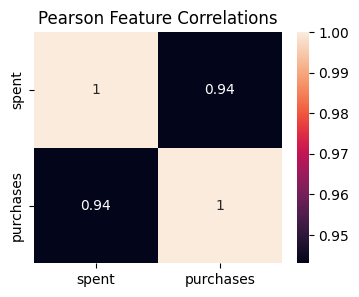

In [10]:
df, _ = get_num_stats(df1)
df

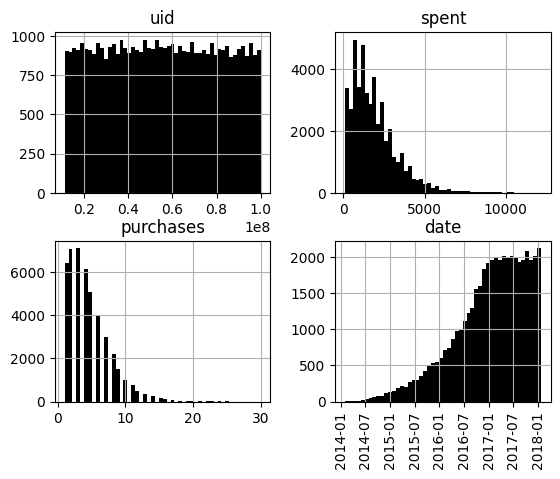

In [14]:
df1.hist(bins=50, color='k');
plt.xticks(rotation=90);

#### 1.6.2. Categorical Attributes

In [ ]:
cat_att = df1.select_dtypes(include=['object'])
cat_att.describe().T

,count,unique,top,freq
country,45883,10,USA,13998
gender,45883,2,M,23116
group,45883,2,A,23009
device,45883,2,A,22982


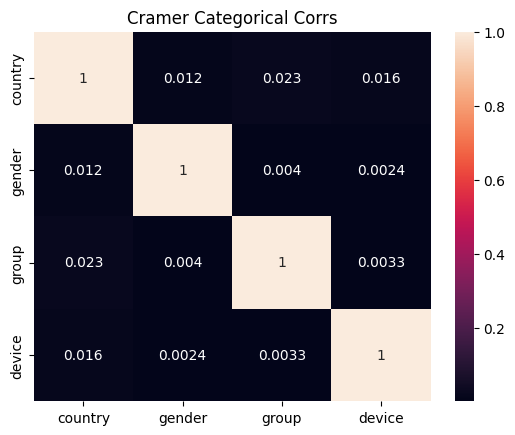

In [ ]:
get_cramer_cors(df1);

#### 1.6.3. Numerical Features per Categories

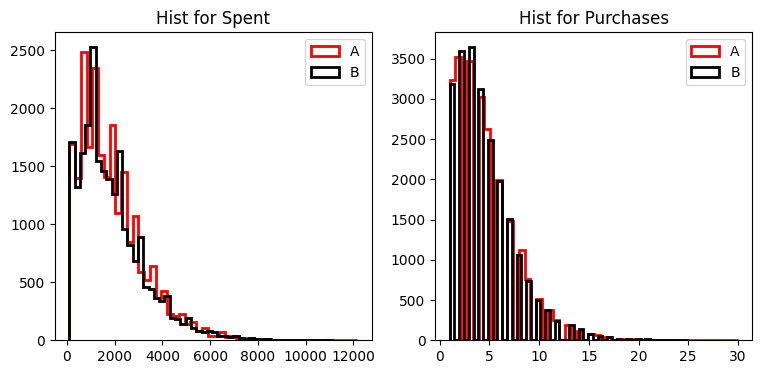

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))
for axi, col in zip([ax[0], ax[1]], ['spent', 'purchases']):
    axi.hist(df1[msk][col], **args(bins=50, label='A'));
    axi.hist(df1[~msk][col], **args(bins=50, label='B', c='k'));
    axi.set_title(f'Hist for {col.capitalize()}')
    axi.legend();

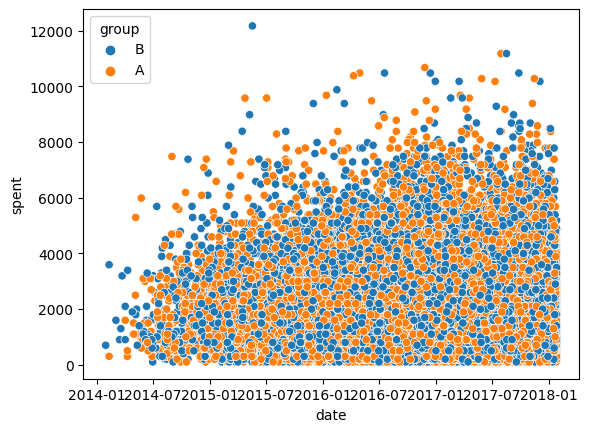

In [77]:
sns.scatterplot(df1, x='date', y='spent', hue='group');

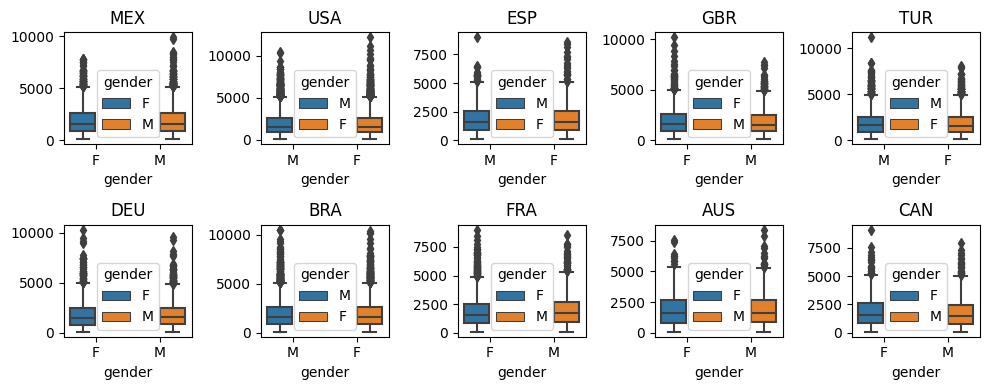

In [111]:
fig, ax = plt.subplots(2, 5, figsize=(10,4))
for axi, col in zip(ax.flatten(), df1.country.unique()):
    aux = df1[df1.country == col][['spent', 'gender']]
    sns.boxplot(x=aux.gender, y=aux['spent'].tolist(), hue=aux.gender, ax=axi)
    axi.set_title(col)
    plt.tight_layout()


## 2.0. Dataset Filtering

In [10]:
df2 = df1.copy()

# Select One Country for Test ( A/B Test need to be in [ One Country / Region ] )
# One effect per time to measure.

df2 = df2[df2['country'] == 'BRA']

tab = pd.crosstab(df2['uid'], df2['group']).reset_index() # Checking Duplicated Users Id
tab[(tab['A'] == 1) & (tab['B'] == 1)]

group,uid,A,B


In [11]:
# Check Control and Treatment Homogenity ( If you have more columns or drop )
df2[['group', 'gender', 'device', 'uid']].groupby(['group', 'gender', 'device']).count().reset_index()

,group,gender,device,uid
0,A,F,A,1044
1,A,F,I,1169
2,A,M,A,1164
3,A,M,I,1141
4,B,F,A,1135
5,B,F,I,1073
6,B,M,A,1149
7,B,M,I,1134


## 3.0. Experiment Design

In [12]:
df3 = df2.copy()

# Auxiliar Column Overlapping
df3['spent_per_purchases'] = df3.apply(lambda x: round(x['spent'] / x['purchases'], 2), axis=1)

### 3.1. Hypothesis Formulation

**Ho**: The averages salves of autocomplete form and manual form input are the same.

**Hi**: The averages salves of autocomplete form and manual form input are different.

### 3.2. Experiment Parameters

In [13]:
df_control = df3[msk]
df_treatment = df3[~msk]

df_control['spent_per_purchases'].mean(), df_treatment['spent_per_purchases'].mean()

(415.31765531062126, 414.2703607791058)

#### 3.2.1. Experiment Parameters Cohen'd

In [28]:
stats_power = .8
confidence_level = .95
significance_level = .05

for col in ['spent_per_purchases', 'purchases']:
    effect_size = compute_effsize(df_control[col].tolist(), df_treatment[col].tolist(), eftype='cohen')
    
    # Statistical Power calculations 
    # for t-test for two independent sample
    
    power_info = power.TTestIndPower()
    
    n = int(power_info.solve_power(
            effect_size=effect_size,
            power=stats_power,
            alpha=significance_level
    ))

    print(f'Effect Size: {effect_size}')
    print(f'Using Column: {col} -> Total samples for test: {n}\n')

Effect Size: 0.008165615493149047
Using Column: spent_per_purchases -> Total samples for test: 235429

Effect Size: 0.005464907267134258
Using Column: purchases -> Total samples for test: 525619



Giant *Minumum* Amount of data for test based on spent / total purchases or purchases. Its because large STDEV, data overlapping and wrong compute effect size value for 2 means.

On TTestIndPower documentation, the effect size formula need to be: "standardized effect size, *difference between the two means divided by the standard deviation*".

#### 3.2.2. Experiment Parameters Manual Formula

In [20]:
stats_power = .8
confidence_level = .95
significance_level = .05

# Standardized Effect Size
# Means Diff and Population BRA Stander dev
# U can use Pingouin if multiply by list values array.

quo_status_effect = df_control.spent.mean()
expected_new_effect = quo_status_effect * 1.05

effect_size =  (expected_new_effect - quo_status_effect) / df2['spent'].std()

power_info = power.TTestIndPower()

n = int(power_info.solve_power(
        effect_size=effect_size,
        power=stats_power,
        alpha=significance_level 
))

print(f'Size of samples: {n}')


Size of samples: 3383


To see a effect of .05, the test requires a min of 3383 samples for each group.

When d = 0.06, the population dist are normal (need samples of same size, need to resample :D), the variability of combine area (u1) is 52.71% **

In [19]:
effect_size

0.0681237214018512

In [17]:
from scipy.stats import norm

u3 = norm.cdf(effect_size)
u2 = norm.cdf(effect_size/2)
u1 = (2*u2 -1) / u2

print(u1*100)
print(u2*100)
print(u3*100)


5.290676479412046
51.35860892117285
52.71564263647588


### 3.3. Sampling Strategy

In [21]:
df_control_sample = df_control.sample(n, random_state=321)
df_treatment_sample = df_treatment.sample(n, random_state=321)

print(f'Size of Control Group: {len(df_control_sample)}')
print(f'Size of Treatment Group: {len(df_treatment_sample)}')

Size of Control Group: 3383
Size of Treatment Group: 3383


### 3.4. Control & Treatment Explicity Metrics

In [80]:
for dfs in [df_control_sample, df_treatment_sample]:
    for col in ['spent', 'purchases']:
        print(f'>>> Group {dfs["group"].iloc[0]}')
        print(f'Mean Of {col} {dfs[col].mean()}')
        print(f'Std  Of {col} {dfs[col].std()}\n')

>>> Group B
Mean Of spent 1910.0502512562814
Std  Of spent 1384.6249887208055

>>> Group B
Mean Of purchases 4.581732190363582
Std  Of purchases 3.1122861324505147

>>> Group A
Mean Of spent 1884.6535619272834
Std  Of spent 1413.1083918149775

>>> Group A
Mean Of purchases 4.527638190954774
Std  Of purchases 3.177536370044033



### 3.5. Apply Statistical Inference Test

In [91]:
t_stats, pvalue = stats.ttest_ind(df_control['spent'], df_treatment['spent'])

if pvalue < significance_level:
    print('Reject Null Hypothesis')
    print('The autocomplete form is really good and have a effect on users experience in Brazil.')
else:
    print('Accept Null Hypothesis')
    print('Automatically complete form did not make a significant difference in sales in Brazil.')

Accept Null Hypothesis
Automatically complete form did not make a significant difference in sales in Brazil.


## 4.0. Convert Results for Business

Expected New Increase for Brazil: 0.05%

In [116]:
df4 = df2.copy()

df4['expected_spent'] = np.ceil(df4['spent'] * 1.05).astype(int)

quo_status_total = df4['spent'].sum()
expected_new_total = df4['expected_spent'].sum()

print(f'Spected New Total Spent: {currency(np.ceil(df4.expected_spent.mean()))}  +/-  {currency(np.ceil(df4.expected_spent.std()))}')
print(f'Best Expected Scenario: {currency(np.ceil(df4.expected_spent.mean() + df4.expected_spent.std()))}')
print(f'Wrost Expected Scenario: {currency(np.ceil(df4.expected_spent.mean() - df4.expected_spent.std()))}')

print(f'\nStatus Quo Total Spent: {currency(np.ceil(df4.spent.mean()))}  +/-  {currency(np.ceil(df4.spent.std()))}')
print(f'Best Status Quo Scenario: {currency(np.ceil(df4.spent.mean() + df4.spent.std()))}')
print(f'Wrost Status Quo Scenario: {currency(np.ceil(df4.spent.mean() - df4.spent.std()))}')

lift = ( expected_new_total - quo_status_total ) / quo_status_total
print(f'\nLift: {lift*100:.2f}%')

#abs_lift = ( expected_new_total - quo_status_total )
#print(f'\nAbs Lift: {abs_lift}')

Spected New Total Spent: R$ 1999,00  +/-  R$ 1469,00
Best Expected Scenario: R$ 3468,00
Wrost Expected Scenario: R$ 530,00

Status Quo Total Spent: R$ 1903,00  +/-  R$ 1399,00
Best Status Quo Scenario: R$ 3302,00
Wrost Status Quo Scenario: R$ 504,00

Lift: 5.01%
